In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from power_prediction.plotting_functions import *

In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [3]:
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

Colour_Palette = ['#01BEFE', '#FF7D00', '#FFDD00', '#FF006D', '#ADFF02', '#8F00FF']
sns.set_palette(sns.color_palette(Colour_Palette))

tqdm.pandas()

In [64]:
df = pd.read_csv('./../data/time_decomposition_remainder_data.csv')
df.head()


,Unnamed: 0,Date,Hr [%Hr],RainDur [min],StrGlo [W/m2],T [°C],WD [°],WVs [m/s],WVv [m/s],p [hPa],NE5_remainder,NE5_yhat,NE7_remainder,NE7_yhat,NETOT_remainder,NETOT_yhat
0,0,2015-01-01 00:00:00,89.25,0.0,0.02,-2.09,20.41,1.40,1.40,982.80,-5003.234382,70677.985082,64950.074562,139851.624086,-9274.801164,210577.611508
1,1,2015-01-01 01:00:00,90.47,0.0,0.01,-2.48,353.85,0.61,0.60,982.64,21913.835976,66833.752524,105908.998422,131060.948724,63548.937026,197941.402420
2,2,2015-01-01 02:00:00,89.45,0.0,0.02,-2.46,21.48,1.31,1.31,983.00,23077.501034,63787.031066,109754.169128,123579.654961,72992.933161,187412.799133
3,3,2015-01-01 03:00:00,89.20,0.0,0.02,-2.63,12.22,1.70,1.66,982.93,20109.861970,64048.871930,98753.991310,119454.426846,63411.904106,183549.693034
4,4,2015-01-01 04:00:00,89.56,0.0,0.02,-2.77,8.30,1.23,1.21,983.03,11981.773823,69151.530277,84971.983503,123196.135870,42861.776534,192395.041346


In [65]:
# Drop unnamed columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head()

,Date,Hr [%Hr],RainDur [min],StrGlo [W/m2],T [°C],WD [°],WVs [m/s],WVv [m/s],p [hPa],NE5_remainder,NE5_yhat,NE7_remainder,NE7_yhat,NETOT_remainder,NETOT_yhat
0,2015-01-01 00:00:00,89.25,0.0,0.02,-2.09,20.41,1.40,1.40,982.80,-5003.234382,70677.985082,64950.074562,139851.624086,-9274.801164,210577.611508
1,2015-01-01 01:00:00,90.47,0.0,0.01,-2.48,353.85,0.61,0.60,982.64,21913.835976,66833.752524,105908.998422,131060.948724,63548.937026,197941.402420
2,2015-01-01 02:00:00,89.45,0.0,0.02,-2.46,21.48,1.31,1.31,983.00,23077.501034,63787.031066,109754.169128,123579.654961,72992.933161,187412.799133
3,2015-01-01 03:00:00,89.20,0.0,0.02,-2.63,12.22,1.70,1.66,982.93,20109.861970,64048.871930,98753.991310,119454.426846,63411.904106,183549.693034
4,2015-01-01 04:00:00,89.56,0.0,0.02,-2.77,8.30,1.23,1.21,983.03,11981.773823,69151.530277,84971.983503,123196.135870,42861.776534,192395.041346


In [67]:
df['Date'] = pd.to_datetime(df['Date'])

In [68]:
df.head()

,Date,Hr [%Hr],RainDur [min],StrGlo [W/m2],T [°C],WD [°],WVs [m/s],WVv [m/s],p [hPa],NE5_remainder,NE5_yhat,NE7_remainder,NE7_yhat,NETOT_remainder,NETOT_yhat
0,2015-01-01 00:00:00,89.25,0.0,0.02,-2.09,20.41,1.40,1.40,982.80,-5003.234382,70677.985082,64950.074562,139851.624086,-9274.801164,210577.611508
1,2015-01-01 01:00:00,90.47,0.0,0.01,-2.48,353.85,0.61,0.60,982.64,21913.835976,66833.752524,105908.998422,131060.948724,63548.937026,197941.402420
2,2015-01-01 02:00:00,89.45,0.0,0.02,-2.46,21.48,1.31,1.31,983.00,23077.501034,63787.031066,109754.169128,123579.654961,72992.933161,187412.799133
3,2015-01-01 03:00:00,89.20,0.0,0.02,-2.63,12.22,1.70,1.66,982.93,20109.861970,64048.871930,98753.991310,119454.426846,63411.904106,183549.693034
4,2015-01-01 04:00:00,89.56,0.0,0.02,-2.77,8.30,1.23,1.21,983.03,11981.773823,69151.530277,84971.983503,123196.135870,42861.776534,192395.041346


Check target variable

In [69]:
print(df['NETOT_remainder'].head())

0    -9274.801164
1    63548.937026
2    72992.933161
3    63411.904106
4    42861.776534
Name: NETOT_remainder, dtype: float64


In [70]:
# Check for missing values
print(df.isnull().sum())

Date                  0
Hr [%Hr]            432
RainDur [min]       150
StrGlo [W/m2]       150
T [°C]              408
WD [°]              139
WVs [m/s]          6384
WVv [m/s]           139
p [hPa]             250
NE5_remainder         1
NE5_yhat              0
NE7_remainder        25
NE7_yhat              0
NETOT_remainder      25
NETOT_yhat            0
dtype: int64


In [71]:
# Remove rows with any None/NaN values
df = df.dropna()

In [72]:
# Check for missing values
print(df.isnull().sum())

Date               0
Hr [%Hr]           0
RainDur [min]      0
StrGlo [W/m2]      0
T [°C]             0
WD [°]             0
WVs [m/s]          0
WVv [m/s]          0
p [hPa]            0
NE5_remainder      0
NE5_yhat           0
NE7_remainder      0
NE7_yhat           0
NETOT_remainder    0
NETOT_yhat         0
dtype: int64


### Plot prepared data

In [73]:
# def data_plot(df, sample_interval=100):
#     # Sample the DataFrame
#     df_plot = df.iloc[::sample_interval, :]  # Adjust the interval as needed
# 
#     ncols = 2
#     nrows = int(np.ceil(df_plot.shape[1] / ncols))  # Ensure enough rows
# 
#     fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(20, 20), dpi=80)
#     ax = ax.flatten()  # Flatten the array for easy indexing
# 
#     for i, col in enumerate(df_plot.columns):
#         ax[i].plot(df_plot.index, df_plot[col], linewidth=0.5)
#         ax[i].tick_params(axis="x", rotation=30, labelsize=8)
#         ax[i].xaxis.set_major_locator(mdates.AutoDateLocator())
#         ax[i].set_title(col)
#         # Remove top and right spines for aesthetics and performance
#         ax[i].spines['top'].set_visible(False)
#         ax[i].spines['right'].set_visible(False)
# 
#     # Hide any unused subplots
#     for j in range(i + 1, len(ax)):
#         fig.delaxes(ax[j])
# 
#     fig.tight_layout()
#     plt.show()
#     
# # Plot the data
# data_plot(df)


In [74]:
# set date as index
df.set_index('Date', inplace=True)
df.head()

,Hr [%Hr],RainDur [min],StrGlo [W/m2],T [°C],WD [°],WVs [m/s],WVv [m/s],p [hPa],NE5_remainder,NE5_yhat,NE7_remainder,NE7_yhat,NETOT_remainder,NETOT_yhat
Date,,,,,,,,,,,,,,
2015-01-01 00:00:00,89.25,0.0,0.02,-2.09,20.41,1.40,1.40,982.80,-5003.234382,70677.985082,64950.074562,139851.624086,-9274.801164,210577.611508
2015-01-01 01:00:00,90.47,0.0,0.01,-2.48,353.85,0.61,0.60,982.64,21913.835976,66833.752524,105908.998422,131060.948724,63548.937026,197941.402420
2015-01-01 02:00:00,89.45,0.0,0.02,-2.46,21.48,1.31,1.31,983.00,23077.501034,63787.031066,109754.169128,123579.654961,72992.933161,187412.799133
2015-01-01 03:00:00,89.20,0.0,0.02,-2.63,12.22,1.70,1.66,982.93,20109.861970,64048.871930,98753.991310,119454.426846,63411.904106,183549.693034
2015-01-01 04:00:00,89.56,0.0,0.02,-2.77,8.30,1.23,1.21,983.03,11981.773823,69151.530277,84971.983503,123196.135870,42861.776534,192395.041346


In [75]:
target_var = ['NETOT_remainder']
feature_var = ['Hr [%Hr]', 'RainDur [min]', 'StrGlo [W/m2]', 'T [°C]', 'WD [°]', 'WVs [m/s]', 'WVv [m/s]', 'p [hPa]']

In [76]:
feature_df = df[feature_var]
target_df = df[target_var]

In [16]:
# Choose scalers
input_scaler = StandardScaler()
target_scaler = StandardScaler()

In [17]:
# Fit scalers on training data
input_scaler.fit(feature_df)
target_scaler.fit(target_df)

StandardScaler()

In [18]:
feature_df_transformed = input_scaler.transform(feature_df)
target_df_transformed = target_scaler.transform(target_df)


In [19]:
# Split data into train and test sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(feature_df_transformed, target_df_transformed, test_size=0.2, random_state=42)

In [20]:
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (62906, 8)
Testing data shape: (15727, 8)


In [21]:
# Convert scaled inputs back to DataFrames
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

# Convert scaled targets back to DataFrames
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)


## Prepare Data for LSTM Input

In [22]:
sequence_length = 10


In [23]:
def create_sequences(inputs, targets, sequence_length):
    Xs, ys = [], []
    for i in range(len(inputs) - sequence_length):
        Xs.append(inputs.iloc[i:(i + sequence_length)].values)
        ys.append(targets.iloc[i + sequence_length].values)
    return np.array(Xs), np.array(ys)

# Create sequences for training data
X_train, y_train = create_sequences(X_train, y_train, sequence_length)

# Create sequences for testing data
X_test, y_test = create_sequences(X_test, y_test, sequence_length)


In [24]:
# Convert numpy arrays to PyTorch tensors and move to GPU
X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.from_numpy(y_train).float().squeeze().to(device)

X_test = torch.from_numpy(X_test).float().to(device)
y_test = torch.from_numpy(y_test).float().squeeze().to(device)

In [25]:
# Create a TensorDataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoaders with a smaller batch size
batch_size = 32 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## Define the LSTM Model

In [26]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Define LSTM layer
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True)
        
        # Output layer
        self.fc = nn.Linear(hidden_size, 1) # Output dimension is 1

    def forward(self, x):
        # Get the device of the input tensor
        device = x.device
    
        # Initialize hidden state and cell state on the same device as the input
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
    
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
    
        # Get output from the last time step
        out = self.fc(out[:, -1, :])
        return out



In [27]:
# Instantiate the model
input_size = X_train.shape[2]  # Number of input features
# hidden_size = 64              
hidden_size = 128
# hidden_size = 256
num_layers = 2                 
# num_layers = 4                 

model = LSTMModel(input_size, hidden_size, num_layers)

In [28]:
# Move data to GPU
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# Move model to GPU
model = model.to(device)


#### Lossfunction and learningrate

In [29]:
# criterion = nn.SmoothL1Loss()
criterion = nn.L1Loss()

# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


In [30]:
# Training loop with DataLoader
num_epochs = 25
for epoch in tqdm(range(num_epochs)):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        output = model(X_batch).squeeze()
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}')


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/25], Loss: 0.8097
Epoch [2/25], Loss: 0.8096
Epoch [3/25], Loss: 0.8094
Epoch [4/25], Loss: 0.8096
Epoch [5/25], Loss: 0.8094
Epoch [6/25], Loss: 0.8096
Epoch [7/25], Loss: 0.8096
Epoch [8/25], Loss: 0.8094
Epoch [9/25], Loss: 0.8094
Epoch [10/25], Loss: 0.8094
Epoch [11/25], Loss: 0.8091
Epoch [12/25], Loss: 0.8095
Epoch [13/25], Loss: 0.8094
Epoch [14/25], Loss: 0.8091
Epoch [15/25], Loss: 0.8094
Epoch [16/25], Loss: 0.8095
Epoch [17/25], Loss: 0.8095
Epoch [18/25], Loss: 0.8094
Epoch [19/25], Loss: 0.8096
Epoch [20/25], Loss: 0.8094
Epoch [21/25], Loss: 0.8095
Epoch [22/25], Loss: 0.8093
Epoch [23/25], Loss: 0.8094
Epoch [24/25], Loss: 0.8094
Epoch [25/25], Loss: 0.8093


## Evaluate the Model

In [31]:
# Create TensorDatasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoaders with smaller batch sizes
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [32]:
# Evaluate the model using DataLoader
model.eval()
y_train_pred = []
y_test_pred = []

with torch.no_grad():
    # Evaluate on training data
    for X_batch, _ in train_loader:
        X_batch = X_batch.to(device)
        y_pred_batch = model(X_batch).squeeze().cpu().numpy()
        y_train_pred.extend(y_pred_batch)

    # Evaluate on testing data
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_pred_batch = model(X_batch).squeeze().cpu().numpy()
        y_test_pred.extend(y_pred_batch)

# Convert predictions to numpy arrays
y_train_pred = np.array(y_train_pred)
y_test_pred = np.array(y_test_pred)

# Move actual values back to CPU for inverse transformation
y_train = y_train.cpu().numpy()
y_test = y_test.cpu().numpy()


In [33]:
# Check the shapes before inverse transformation
print("Shapes before inverse transform:")
print(f"y_train_actual: {y_train.shape}")
print(f"y_train_pred_actual: {y_train_pred.shape}")
print(f"y_test_actual: {y_test.shape}")
print(f"y_test_pred_actual: {y_test_pred.shape}")

# Reshape if necessary (inverse_transform expects 2D array)
if y_train.ndim == 1:
    y_train = y_train.reshape(-1, 1)
    y_train_pred = y_train_pred.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    y_test_pred = y_test_pred.reshape(-1, 1)

# Inverse transform
y_train = target_scaler.inverse_transform(y_train).flatten()
y_train_pred = target_scaler.inverse_transform(y_train_pred).flatten()
y_test = target_scaler.inverse_transform(y_test).flatten()
y_test_pred = target_scaler.inverse_transform(y_test_pred).flatten()

# Print a sample of the actual and predicted values after inverse transform
print("Sample actual vs. predicted (training set):")
print(y_train[:5], y_train_pred[:5])

print("Sample actual vs. predicted (testing set):")
print(y_test[:5], y_test_pred[:5])

# Calculate metrics for training data
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
train_mape = mean_absolute_percentage_error(y_train, y_train_pred)

# Calculate metrics for testing data
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

# Create a DataFrame to display the results
results_df = pd.DataFrame({
    "Metric": ["MSE", "MAE", "R²", "MAPE"],
    "Train": [train_mse, train_mae, train_r2, train_mape],
    "Test": [test_mse, test_mae, test_r2, test_mape]
})

# Display the DataFrame
print(results_df)

# Check for potential outliers in the target variable
print("Checking for potential outliers in the target variable:")
print(f"Max value of y_train_actual: {np.max(y_train)}")
print(f"Max value of y_test_actual: {np.max(y_test)}")

Shapes before inverse transform:
y_train_actual: (62896,)
y_train_pred_actual: (62896,)
y_test_actual: (15717,)
y_test_pred_actual: (15717,)
Sample actual vs. predicted (training set):
[-14172.767  -13934.499  -35960.53     -796.2035  21471.38  ] [-1466.9056 -1285.6302 -1469.8064 -1387.0541 -1328.7594]
Sample actual vs. predicted (testing set):
[-12450.915    8120.6387 -32003.46    15307.242  -25480.658 ] [ -405.8796  -618.5624 -1169.735  -1236.2612 -1195.0532]
  Metric         Train          Test
0    MSE  5.874945e+08  5.872250e+08
1    MAE  1.960658e+04  1.959760e+04
2     R² -1.736164e-03 -1.036167e-03
3   MAPE  1.346068e+00  1.554684e+01
Checking for potential outliers in the target variable:
Max value of y_train_actual: 84301.3828125
Max value of y_test_actual: 82289.8515625


In [29]:
# # For training data
# train_dates = train_df.index[sequence_length:]
# 
# # For testing data
# test_dates = test_df.index[sequence_length:]
# 
# # Ensure dates match the length of your predictions
# train_dates = train_dates[:len(y_train_actual)]
# test_dates = test_dates[:len(y_test_actual)]

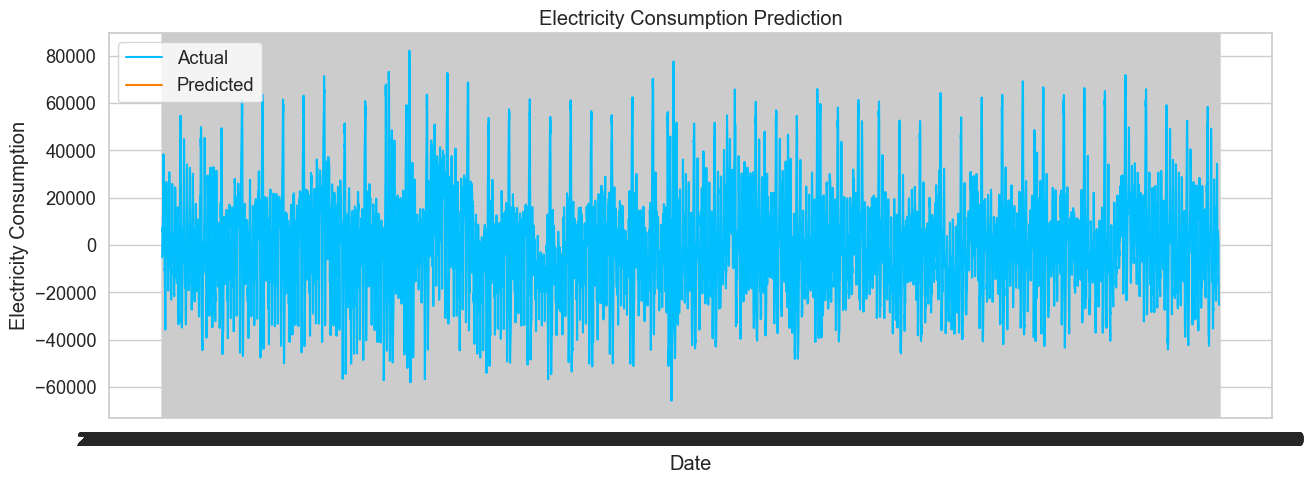

In [30]:
# import matplotlib.pyplot as plt
# 
# # Plotting the test results
# plt.figure(figsize=(15,5))
# plt.plot(test_dates, y_test_actual, label='Actual')
# plt.plot(test_dates, y_test_pred_actual, label='Predicted')
# plt.title('Electricity Consumption Prediction')
# plt.xlabel('Date')
# plt.ylabel('Electricity Consumption')
# plt.legend()
# plt.show()


In [78]:
dates = test_dates(target_df, y_test)

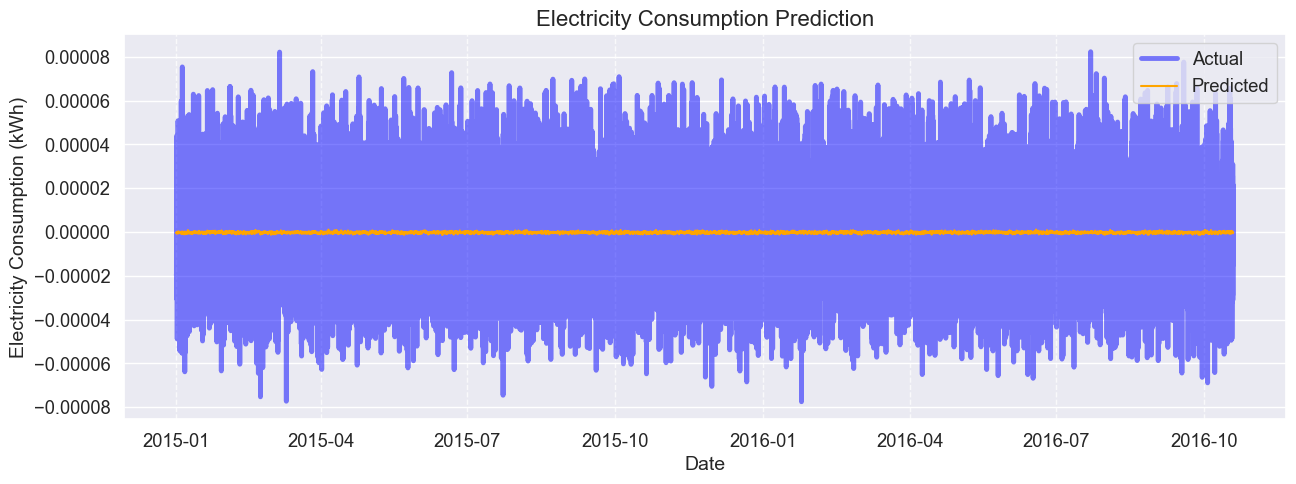

In [79]:
line_plot_pred(dates, y_test, y_test_pred)